# Dive Prediction - Matrix Distance Simple Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 100s
* *Output resolution*: 10s
* *Representation of trajectories* : Matrix Distance
* *Layers* : 1x1 convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/data_train.csv')
data_validation = pd.read_csv('./data/data_validation.csv')
data_test = pd.read_csv('./data/data_test.csv')

## choose window

In [5]:
# Hyperparameters
window = 100
rescale = 10
variable = ('lon', 'lat')

train_set = TrajDataSet(data_train, window, variable)
d = DistMatrix()
r = Rescale(rescale)

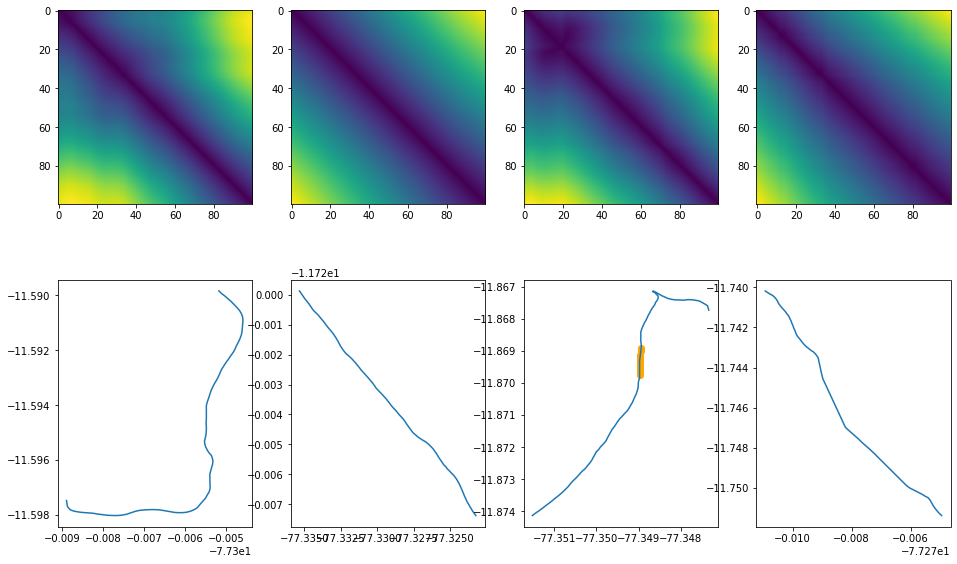

In [6]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, dive = train_set[i]
    matrix_dist, dive = r(d(train_set[i]))
    

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    dive = [dive[i] for i in range(len(dive)) for k in range(rescale) ]
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [7]:
# hyperparameters
batch_size = 64
learning_rate = 0.01

## reduce size dataset
train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
validation_set = TrajDataSet(data_validation, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [8]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.threshold_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 4, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.threshold_2 = nn.Sequential(
            nn.BatchNorm1d(4),
            nn.AvgPool1d(kernel_size = rescale, stride = rescale),
            nn.ReLU(),
            nn.Conv1d(4, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True)
            
        )
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.threshold_1(x)
        out = torch.sum(out, 2)
        out = self.threshold_2(out)
        return out


def get_score(out, y):
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))
#     return (true_positive.detach().numpy().item() , true_negative.detach().numpy().item())

In [9]:
# get sample
x, y = next(iter(train_loader)) 

# Forward model
model = ConvNet()
out = model(x)

# Loss and score
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([15]))
criterion(out, y)
get_score(out, y)

(0.0, 99.0)

## Training

In [10]:
# # switch to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [11]:
# Train the model
nb_epoch = 3
weight = torch.FloatTensor([15])
learning_rate = 0.01

list_loss_train = []
list_score_train = []

list_loss_validation = []
list_score_validation = []


for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y) in enumerate(train_loader):
        i+=1
    #     # send to GPU
    #     x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score = get_score(out,y)
        list_loss_train.append(loss.item())
        list_score_train.append(score)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Batch Loss: {}, Batch True Positive : {}, Batch True Negative : {} %'
                    .format(epoch+1, nb_epoch, i + 1, len(train_loader), loss.item(), score[0], score[1]))
            
            
    ### - Validation every epoch
    model.eval()
    with torch.no_grad():
        j = 0
        for batch, (x, y) in enumerate(validation_loader):
            j+= 1
            # Run the forward pass
            out = model(x)
            loss = criterion(out, y)
            score = get_score(out,y)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)


    global_loss = np.mean(list_loss_validation)
    global_trueP = np.mean([tp for (tp, tn) in list_score_validation])
    global_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Validation -------------------------------------------------------------------------------------')
    print('Epoch [{}/{}], Validation Loss: {}, Validation True Positive : {}, Validation True Negative : {} %'
            .format(epoch+1, nb_epoch, global_loss, global_trueP, global_trueN))
    print('------------------------------------------------------------------------------------------------')
    model.train()

Epoch [1/3], Step [100/2614], Batch Loss: 0.7659324407577515, Batch True Positive : 0.0, Batch True Negative : 100.0 %
Epoch [1/3], Step [200/2614], Batch Loss: 0.9631264805793762, Batch True Positive : 44.0, Batch True Negative : 85.0 %
Epoch [1/3], Step [300/2614], Batch Loss: 1.0864150524139404, Batch True Positive : 55.0, Batch True Negative : 81.0 %
Epoch [1/3], Step [400/2614], Batch Loss: 0.8981598615646362, Batch True Positive : 75.0, Batch True Negative : 76.0 %
Epoch [1/3], Step [500/2614], Batch Loss: 0.966746985912323, Batch True Positive : 68.0, Batch True Negative : 72.0 %
Epoch [1/3], Step [600/2614], Batch Loss: 0.7121822237968445, Batch True Positive : 76.0, Batch True Negative : 76.0 %
Epoch [1/3], Step [700/2614], Batch Loss: 0.8271112442016602, Batch True Positive : 77.0, Batch True Negative : 78.0 %
Epoch [1/3], Step [800/2614], Batch Loss: 0.6343322992324829, Batch True Positive : 81.0, Batch True Negative : 77.0 %
Epoch [1/3], Step [900/2614], Batch Loss: 0.77858

## Testing

In [12]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    print(i)

P1108_46_SV_T2
P1111_41_SV_T4
P1112_10_SV_T2
P1112_15_SV_T3
P1112_20_SV_T4
P1112_31_SV_T5
P1113_28_SV_T1


In [13]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

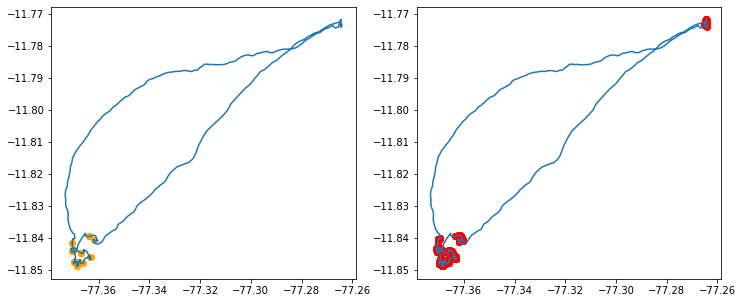

In [14]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

## score

In [15]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

(0.7021276595744681, 0.7780407004259347)

(0.8571428571428571, 0.7830578512396694)
(0.5714285714285714, 0.9080459770114943)
(0.0, 0.9137380191693291)
(0.84375, 0.5574229691876751)
(0.8181818181818182, 0.7469879518072289)
(0.45454545454545453, 0.8176470588235294)
(0.6923076923076923, 0.7813620071684588)


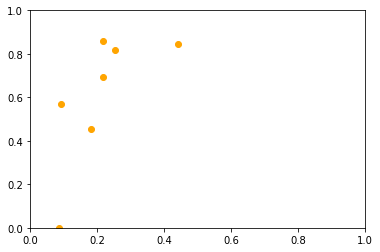

In [16]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

Change the decision threshold

In [17]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-5, 5, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

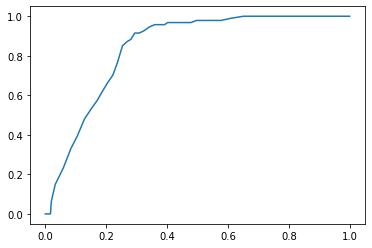

In [18]:
plt.plot(np.array(FP), np.array(TP))

In [19]:
data = {'model': 'simple_network_matrix',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('./roc_simple_network_matrix.csv', index = False)

# Export Probabilities

In [21]:
all_real = np.hstack(dive_real)
all_estim = np.hstack(dive_estim)
all_proba_estim = 1/(1+np.exp(-all_estim))
all_proba_estim

array([0.11419339, 0.1582213 , 0.20500105, ..., 0.01716014, 0.01293666,
       0.02064631])

In [22]:
trip_name = data_test.trip.unique()
trip_length = [len(i) for i in dive_estim]
trip = [trip_name[i] for i in range(len(trip_name)) for k in range(trip_length[i])]

In [23]:
data = {'model': 'simple_network_matrix',
        'trip':  trip,
        'real': all_real,
        'p': all_proba_estim
        }

df = pd.DataFrame (data, columns = ['model','trip', 'real', 'p'])

df.to_csv('prob_simple_network_matrix.csv', index = False)